In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from collections import defaultdict  # For word frequency
import numpy as np
import sklearn

import spacy  # For preprocessing

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
df_nlp2019=pd.read_excel("E:/Project/Final Project DSI/Dataset/Data DJPK/clean_APBD_2019.xlsx")
df_nlp2020=pd.read_excel("E:/Project/Final Project DSI/Dataset/Data DJPK/clean_APBD_2020.xlsx")
df_nlp2021=pd.read_excel("E:/Project/Final Project DSI/Dataset/Data DJPK/clean_APBD_2021.xlsx")

In [3]:
df_nlp2019.head(10)

,Unnamed: 0,Akun Analisis,Namakegiatan,Namakegiatan_stem,standarpemda,Tahun,Nilaianggaran
0,0,41. PAD,pendapatan,dapat,Provinsi Aceh,2019,1.509791e+12
1,1,41. PAD,pendapatan,dapat,Provinsi Aceh,2019,2.886440e+10
2,2,41. PAD,pendapatan,dapat,Provinsi Aceh,2019,1.969350e+11
3,3,41. PAD,pendapatan,dapat,Provinsi Aceh,2019,7.460386e+11
4,4,41. PAD,non,non,Kab. Aceh Barat,2019,1.630089e+10
5,5,41. PAD,non,non,Kab. Aceh Barat,2019,9.968104e+09
6,6,41. PAD,non,non,Kab. Aceh Barat,2019,4.700000e+09
7,7,41. PAD,non,non,Kab. Aceh Barat,2019,1.377243e+11
8,8,41. PAD,pendapatan,dapat,Kab. Aceh Besar,2019,6.090002e+10
9,9,41. PAD,pendapatan,dapat,Kab. Aceh Besar,2019,5.907310e+09


In [4]:
df_nlp2019.shape

(699801, 7)

In [5]:
df_nlp2019.isnull().sum()

Unnamed: 0            0
Akun Analisis         0
Namakegiatan         40
Namakegiatan_stem    40
standarpemda          0
Tahun                 0
Nilaianggaran         0
dtype: int64

In [6]:
df_real2019=df_nlp2019.fillna('').copy()

In [7]:
df_real2019.isnull().sum()

Unnamed: 0           0
Akun Analisis        0
Namakegiatan         0
Namakegiatan_stem    0
standarpemda         0
Tahun                0
Nilaianggaran        0
dtype: int64

In [9]:
#df_coba=df_nlp.drop(['Akun Analisis','Kodepemda','standarpemda'],axis=1)

In [10]:
#df_coba.head()

,Unnamed: 0,id,Namakegiatan,Namaprogram,standarjenis,standarkelompok,standarutama,nilaianggaran
0,0,0,"['hitung', 'fihak', 'tiga', 'badan', 'kelola',...","['non', 'program']",NaN,NaN,NaN,2.221547e+11
1,1,1,['all'],['all'],All,All,NaN,2.221547e+11
2,2,2,['all'],['all'],All,All,All,2.221547e+11
3,3,3,"['non', 'giat']","['non', 'program']",411. Pajak Daerah,41. Pendapatan Asli Daerah,4. Pendapatan Daerah,1.477991e+12
4,4,4,"['non', 'giat']","['non', 'program']",412. Retribusi Daerah,41. Pendapatan Asli Daerah,4. Pendapatan Daerah,8.159970e+09


In [8]:
nlp = spacy.load("en_core_web_sm")

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [9]:
coba_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df_real2019['Namakegiatan'])

In [10]:
txt = [cleaning(doc) for doc in nlp.pipe(coba_cleaning, batch_size=5000, n_process=-1)]

In [17]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(269071, 1)

In [18]:
from gensim.models.phrases import Phrases, Phraser

In [19]:
sent = [row.split() for row in df_clean['clean']]

In [20]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [21]:
bigram = Phraser(phrases)

In [22]:
sentences = bigram[sent]

In [23]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

42112

In [24]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['peningkatan',
 'daerah',
 'pembangunan',
 'pelayanan',
 'pembinaan',
 'pengembangan',
 'penyusunan',
 'pengelolaan',
 'kesehatan',
 'pelaksanaan']

In [25]:
import multiprocessing

from gensim.models import Word2Vec

In [26]:
cores = multiprocessing.cpu_count()

In [27]:
w2v_model = Word2Vec(min_count=10,
                     window=2,
                     vector_size=15,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     workers=cores-1)

In [28]:
w2v_model.build_vocab(sentences, progress_per=10000)

In [29]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1)

(30899085, 68617100)

In [30]:
w2v_model.init_sims(replace=True)

<ipython-input-30-c7757d71a30b>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [31]:
w2v_model.wv.most_similar(positive=["sehat"])

[('generasi', 0.8791127800941467),
 ('mewujudkan', 0.8299694657325745),
 ('berencana', 0.8211790323257446),
 ('tatanan', 0.8184030652046204),
 ('phbs', 0.8115586042404175),
 ('hkg', 0.810251772403717),
 ('cerda', 0.8049840927124023),
 ('phb', 0.7922348976135254),
 ('genre', 0.7906855344772339),
 ('gsc', 0.7894072532653809)]

In [32]:
w2v_model.wv.most_similar(positive=["pariwisata"])

[('kepariwisataan', 0.8622426986694336),
 ('ekonomi_kreatif', 0.8578368425369263),
 ('amenitas', 0.8275954723358154),
 ('destinasi', 0.8199442028999329),
 ('parawisata', 0.8120473027229309),
 ('promosi', 0.7846353054046631),
 ('kebudayaan', 0.7813993692398071),
 ('jawa_barat', 0.7782281637191772),
 ('investor', 0.7723970413208008),
 ('pemasaran', 0.7707918882369995)]

In [33]:
w2v_model.wv.most_similar(positive=["umkm"])

[('akse_permodalan', 0.9533522725105286),
 ('usaha_mikro', 0.9406574964523315),
 ('kukm', 0.9323394298553467),
 ('koperasi_umkm', 0.9166988730430603),
 ('pemasaran_produk', 0.8903005123138428),
 ('menengah', 0.875411868095398),
 ('kumkm', 0.8662891387939453),
 ('dagang', 0.8570902347564697),
 ('ikm', 0.8535501956939697),
 ('promosi_produk', 0.8524512052536011)]

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [35]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 15), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


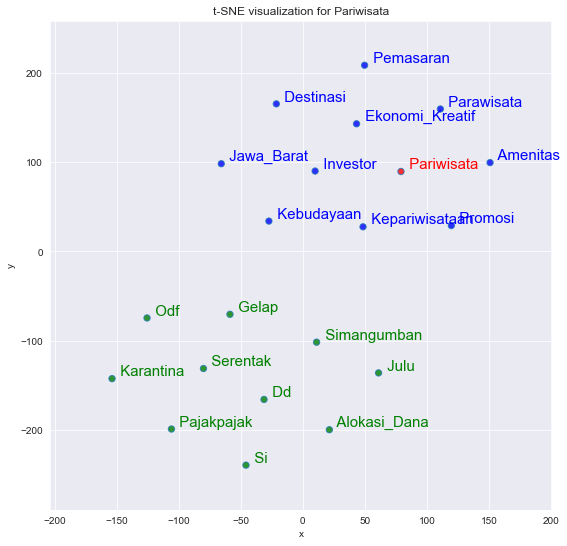

In [36]:
tsnescatterplot(w2v_model, 'pariwisata', [i[0] for i in w2v_model.wv.most_similar(negative=["pariwisata"])])

D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


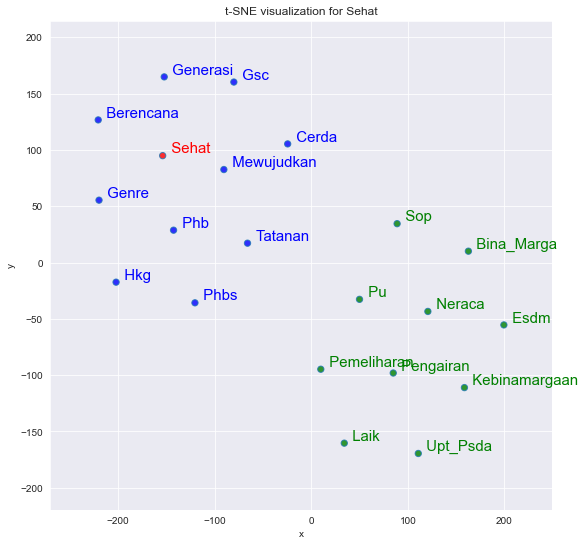

In [37]:
tsnescatterplot(w2v_model, 'sehat', [i[0] for i in w2v_model.wv.most_similar(negative=["sehat"])])

D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


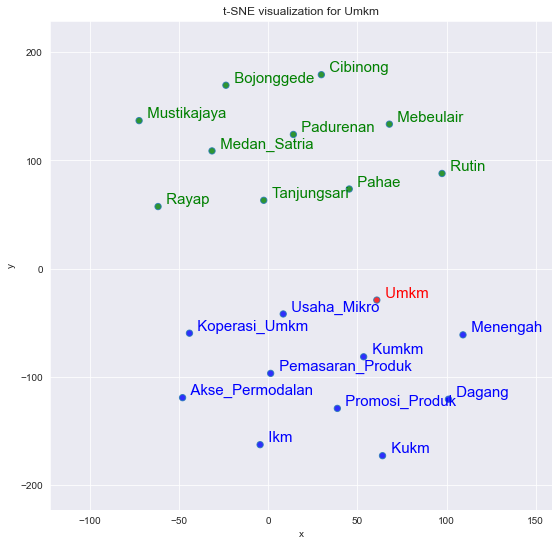

In [38]:
tsnescatterplot(w2v_model, 'umkm', [i[0] for i in w2v_model.wv.most_similar(negative=["umkm"])])

In [39]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [40]:
vectorized_docs = vectorize(sentences, model=w2v_model)
len(vectorized_docs), len(vectorized_docs[0])

(269071, 15)

In [37]:
#def mbkmeans_clusters(
#	X, 
#    k, 
#    mb, 
#    print_silhouette_values, 
#):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
#    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
#    print(f"For n_clusters = {k}")
#    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
#    print(f"Inertia:{km.inertia_}")

#    if print_silhouette_values:
#        sample_silhouette_values = silhouette_samples(X, km.labels_)
#        print(f"Silhouette values:")
#        silhouette_values = []
#        for i in range(k):
#            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
#            silhouette_values.append(
#                (
#                    i,
#                    cluster_silhouette_values.shape[0],
#                    cluster_silhouette_values.mean(),
#                    cluster_silhouette_values.min(),
#                    cluster_silhouette_values.max(),
#                )
#            )
#        silhouette_values = sorted(
#            silhouette_values, key=lambda tup: tup[2], reverse=True
#        )
#        for s in silhouette_values:
#            print(
#                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
#            )
#    return km, km.labels_

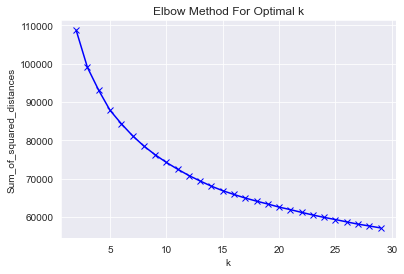

In [41]:
Sum_of_squared_distances = []
K = range(2,30)

for k in K:
   km = KMeans(n_clusters=k, max_iter=300, n_init=10)
   km = km.fit(vectorized_docs)
   Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [43]:
true_k = 15
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=300, n_init=10)
model.fit(vectorized_docs)
labels=model.labels_
results=pd.DataFrame(list(zip(df_real2019['Namakegiatan'],labels)),columns=['Namakegiatan','cluster'])
print(results.sort_values(by=['cluster']))

                                             Namakegiatan  cluster
141908                         penyusunan laporan tahunan        0
136145             pengadaan neon box monumen sanga sanga        0
136146                                     pengadaan obat        0
15120           penyediaan barang jasa operasional kantor        0
136180  pengadaan sarana prasarana penangkapan ikan ba...        0
...                                                   ...      ...
251823           pembinaan olahraga berkembang masyarakat       14
251822          pembinaan nelayan pengolah pemasaran ikan       14
251821                       pembinaan nagari berprestasi       14
251819                                      pembinaan lpm       14
26789   kajian peraturan perundangundangan daerah pera...       14

[269071 rows x 2 columns]


Cluster: 0


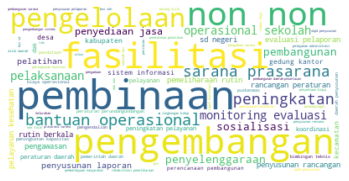

Cluster: 1


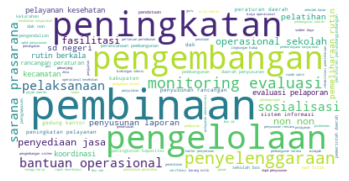

Cluster: 2


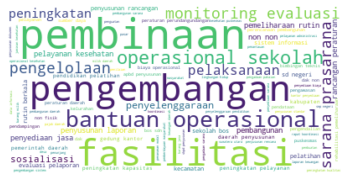

Cluster: 3


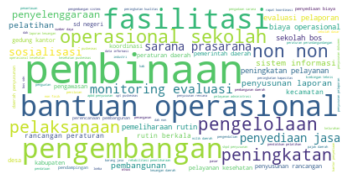

Cluster: 4


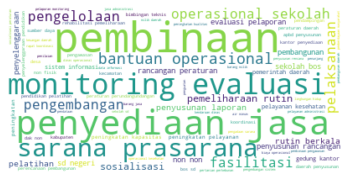

Cluster: 5


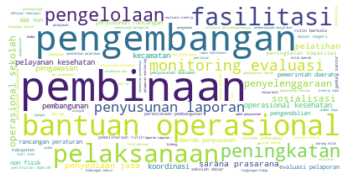

Cluster: 6


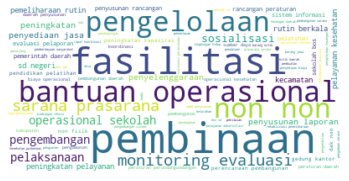

Cluster: 7


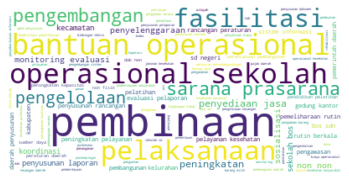

Cluster: 8


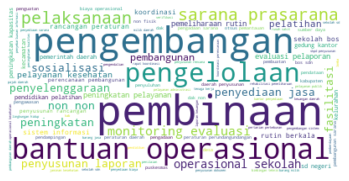

Cluster: 9


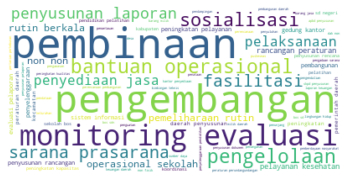

Cluster: 10


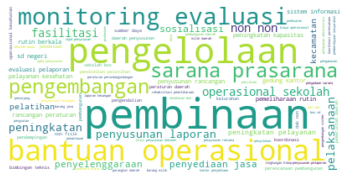

Cluster: 11


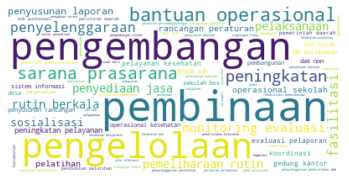

Cluster: 12


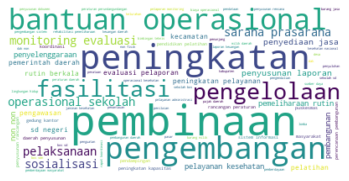

Cluster: 13


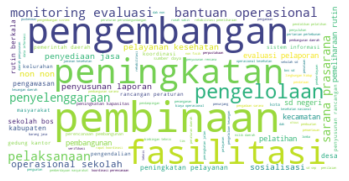

Cluster: 14


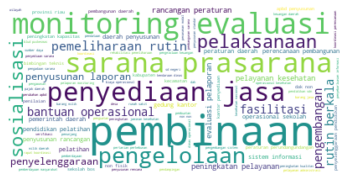

In [44]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

result= results

for k in range(0,true_k):
   s=result[result.cluster==k].astype(str)
   text=s['Namakegiatan'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   titles=results[results.cluster==k]['Namakegiatan']         
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

# 2020 

In [45]:
df_nlp2020.isnull().sum()

Unnamed: 0           0
Akun Analisis        0
Namakegiatan         2
Namakegiatan_stem    2
standarpemda         0
Tahun                0
Nilaianggaran        0
dtype: int64

In [46]:
df_real2020=df_nlp2020.fillna('').copy()

In [50]:
df_real2020.isnull().sum()

Unnamed: 0           0
Akun Analisis        0
Namakegiatan         0
Namakegiatan_stem    0
standarpemda         0
Tahun                0
Nilaianggaran        0
dtype: int64

In [49]:
coba_cleaning_2020 = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df_real2020['Namakegiatan'])

In [51]:
txt_2020 = [cleaning(doc) for doc in nlp.pipe(coba_cleaning_2020, batch_size=5000, n_process=-1)]

In [52]:
df_clean2020 = pd.DataFrame({'clean': txt})
df_clean2020 = df_clean2020.dropna().drop_duplicates()
df_clean2020.shape

(269071, 1)

In [53]:
from gensim.models.phrases import Phrases, Phraser

sent = [row.split() for row in df_clean2020['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [54]:
word_freq_2020 = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq_2020[i] += 1
len(word_freq)

42112

In [55]:
sorted(word_freq_2020, key=word_freq.get, reverse=True)[:10]

['peningkatan',
 'daerah',
 'pembangunan',
 'pelayanan',
 'pembinaan',
 'pengembangan',
 'penyusunan',
 'pengelolaan',
 'kesehatan',
 'pelaksanaan']

In [56]:
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count()

w2v_model_2020 = Word2Vec(min_count=10,
                     window=2,
                     vector_size=15,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     workers=cores-1)

In [57]:
w2v_model_2020.build_vocab(sentences, progress_per=10000)

In [58]:
w2v_model_2020.train(sentences, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1)

(30908653, 68617100)

In [59]:
w2v_model_2020.init_sims(replace=True)

<ipython-input-59-3a0f6e65df8f>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model_2020.init_sims(replace=True)


In [60]:
w2v_model_2020.wv.most_similar(positive=["sehat"])

[('germa', 0.8232864141464233),
 ('ibuibu', 0.8207811713218689),
 ('gema', 0.8194305896759033),
 ('kesrak', 0.8075898885726929),
 ('phbs', 0.8061535358428955),
 ('phb', 0.7997241020202637),
 ('berseri', 0.7885669469833374),
 ('pkkkb', 0.7869829535484314),
 ('pemilihan_duta', 0.7793266773223877),
 ('harmonis', 0.7745793461799622)]

In [61]:
w2v_model_2020.wv.most_similar(positive=["pariwisata"])

[('ekonomi_kreatif', 0.8612387180328369),
 ('kepariwisataan', 0.8282034397125244),
 ('destinasi', 0.8259576559066772),
 ('amenitas', 0.8175727128982544),
 ('parawisata', 0.8144850730895996),
 ('industri_kreatif', 0.7869607210159302),
 ('galeri', 0.7837444543838501),
 ('pertunjukan', 0.7770394682884216),
 ('atraksi', 0.7696124315261841),
 ('lokal', 0.7691411375999451)]

In [62]:
w2v_model_2020.wv.most_similar(positive=["umkm"])

[('usaha_mikro', 0.9331558346748352),
 ('kukm', 0.9118677377700806),
 ('akse_permodalan', 0.8904836177825928),
 ('ikm', 0.8852414488792419),
 ('kumkm', 0.8786226511001587),
 ('ukm', 0.8753014206886292),
 ('pemasaran_produk', 0.872292697429657),
 ('dagang', 0.8715396523475647),
 ('promosi_produk', 0.8639729619026184),
 ('industri_menengah', 0.8634430170059204)]

D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


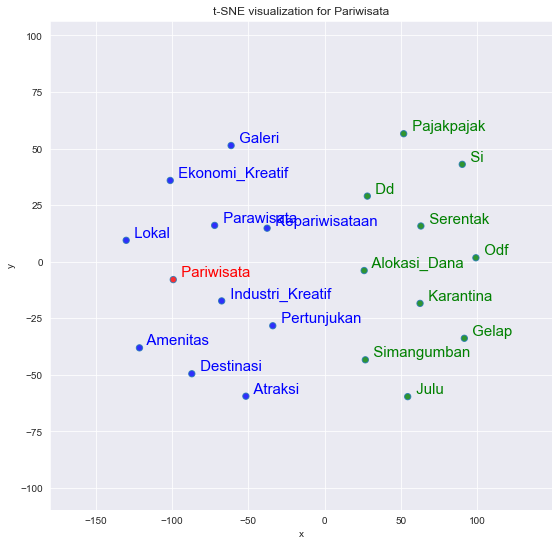

In [63]:
tsnescatterplot(w2v_model_2020, 'pariwisata', [i[0] for i in w2v_model.wv.most_similar(negative=["pariwisata"])])

D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


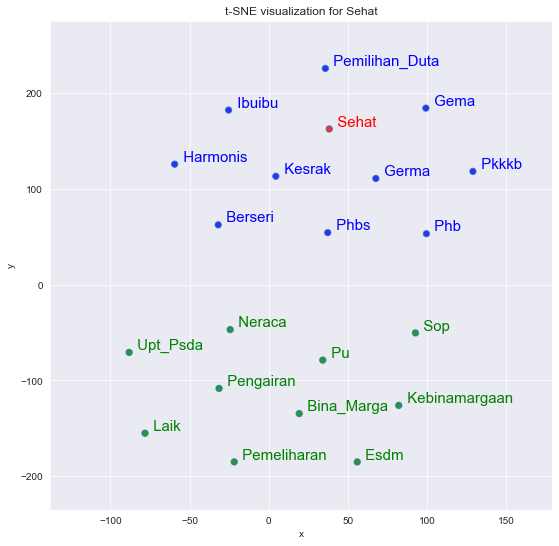

In [64]:
tsnescatterplot(w2v_model_2020, 'sehat', [i[0] for i in w2v_model.wv.most_similar(negative=["sehat"])])

D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


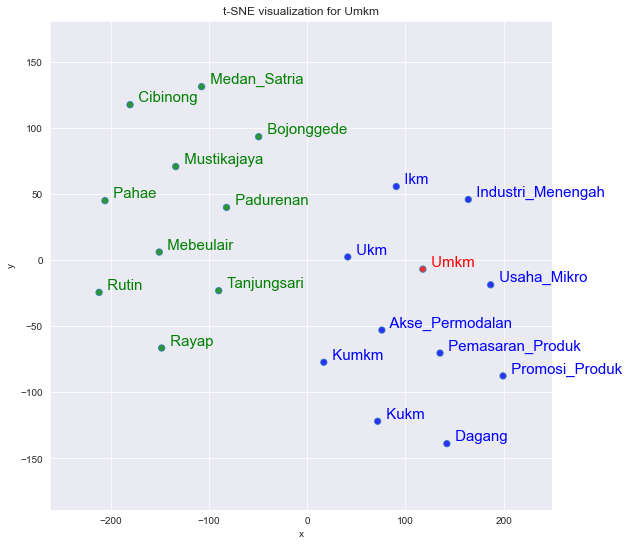

In [65]:
tsnescatterplot(w2v_model_2020, 'umkm', [i[0] for i in w2v_model.wv.most_similar(negative=["umkm"])])

In [66]:
vectorized_docs_2020 = vectorize(sentences, model=w2v_model_2020)
len(vectorized_docs_2020), len(vectorized_docs_2020[0])

(269071, 15)

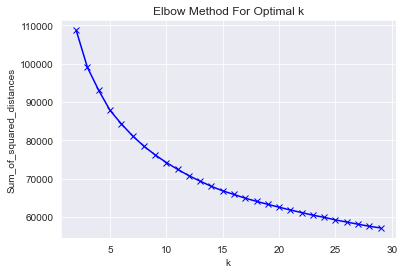

In [67]:
Sum_of_squared_distances = []
K = range(2,30)

for k in K:
   km = KMeans(n_clusters=k, max_iter=300, n_init=10)
   km = km.fit(vectorized_docs)
   Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [68]:
true_k = 12
model2020 = KMeans(n_clusters=true_k, init='k-means++', max_iter=300, n_init=10)
model2020.fit(vectorized_docs)
labels=model2020.labels_
results2020=pd.DataFrame(list(zip(df_real2020['Namakegiatan'],labels)),columns=['Namakegiatan','cluster'])
print(results2020.sort_values(by=['cluster']))

                                             Namakegiatan  cluster
269070    pengadaan pakaian dinas beserta perlengkapannya        0
113081  sosialisasi nasionalisme bebas narkoba generas...        0
113079  sosialisasi penggunaan bahan berbahaya produk ...        0
38011                        pembangunan jaringan irigasi        0
38012                                pembangunan jembatan        0
...                                                   ...      ...
166587  pengamanan raya keagamaan olahraga kota cilego...       11
166588                pengamanan kebersihan khusus daerah       11
166632        peningkatan administrasi kepegawaian kp pns       11
166368                            o2s smp tingkat cilegon       11
134535  penyusunan prioritas plafon anggaran ppas apbd...       11

[269071 rows x 2 columns]


Cluster: 0


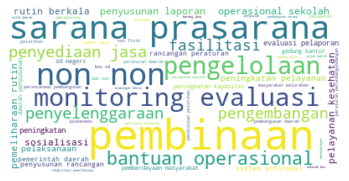

Cluster: 1


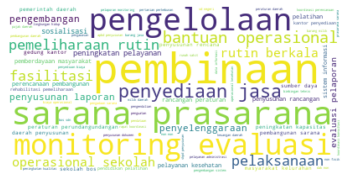

Cluster: 2


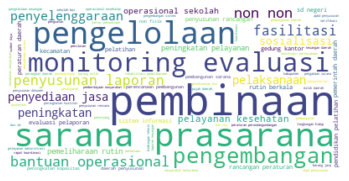

Cluster: 3


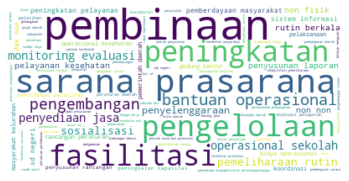

Cluster: 4


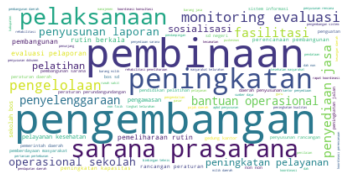

Cluster: 5


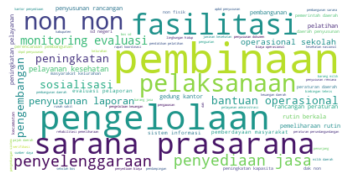

Cluster: 6


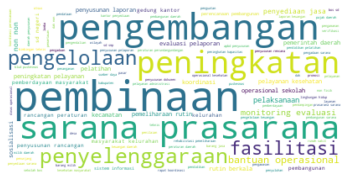

Cluster: 7


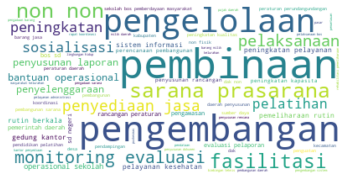

Cluster: 8


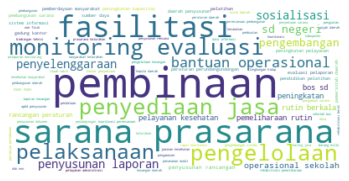

Cluster: 9


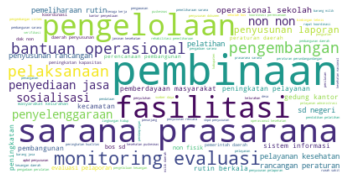

Cluster: 10


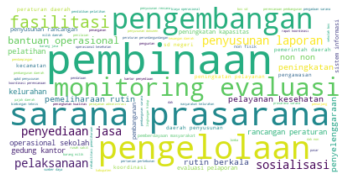

Cluster: 11


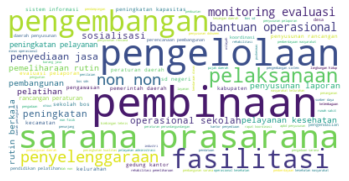

In [69]:
result2020= results2020

for k in range(0,true_k):
   s=result2020[result2020.cluster==k].astype(str)
   text=s['Namakegiatan'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   titles=results2020[results2020.cluster==k]['Namakegiatan']         
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

In [70]:
w2v_model_2020.wv.most_similar(positive=["pembinaan"])

[('pembinaaan', 0.9154806137084961),
 ('pembianaan', 0.9048312902450562),
 ('peran', 0.9026467204093933),
 ('peranan', 0.896655797958374),
 ('penguatan_kapasitas', 0.8783959746360779),
 ('kapasita', 0.867196261882782),
 ('kapasita_kelembagaan', 0.8512060642242432),
 ('pemberdayaan', 0.8505398035049438),
 ('kelembagaan', 0.8415281176567078),
 ('peningkatan_kapasitas', 0.8353210091590881)]